[Simple plotter](#Simple-plotter)

# Fast variable plotter

In [1]:
import pandas as pd
import json
import os
import pyarrow
from keras.models import model_from_json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
import matplotlib.ticker as tck
from sklearn.metrics import roc_auc_score
from IPython.display import HTML, display

#Plot style
plt.style.use('classic')
rcParams['figure.facecolor'] = '1'
rcParams['patch.force_edgecolor'] = False
rcParams['legend.numpoints'] = 1
rcParams['lines.markeredgewidth']=0.0
fpath = os.path.join(rcParams["datapath"], "/nfs/pic.es/user/s/salvador/arial.ttf")
fbipath = os.path.join(rcParams["datapath"], "/nfs/pic.es/user/s/salvador/ArialBoldItalic.ttf")

#Useful functions
def ATLAS(ylims,perc):
    #gets axis coordinates in units of %
    width=ylims[1]-ylims[0]
    return ylims[0]+width*perc
def getlogticks(ticklist):
    #custom format of logarithm log ticks
    aux = [r"10$^{"+str(int(np.log10(i)))+"}$" for i in ticklist]
    return ["1" if x=='10$^{0}$' else "10" if x=='10$^{1}$' else x for x in aux]

from joblib import load, dump
outputdir = "./Plots_Wh"
user = "salvador"

pandainput = "pandas_Wh_v0_6jin4bin.feather"

In [2]:
if not os.path.isdir(outputdir):
    print("Making output dir",outputdir)
    os.makedirs(outputdir, exist_ok=True)
if not os.path.isdir("/tmp/"+user):
    print ("Making tmp dir")
    os.mkdir("/tmp/"+user)

!ls -sh /nfs/at3/scratch/salvador/IFAE-tXq/NN/IFAE-NNTools/PandasWriter/

total 4.6G
4.0K CreatePandas_tqX.py    2.1G pandas_tqX.feather		8.0K tqXData.py
4.0K CreatePandas_tqX.py~   2.1G pandas_tqXv0.feather		8.0K WhData.py
4.0K CreatePandas_Wh.py     370M pandas_Wh_v0_6jin4bin.feather	8.0K WhData.py~
 16K pandasconfig_tqX.json     0 __pycache__
8.0K pandasconfig_Wh.json   4.0K setup.sh


In [3]:
!cp /nfs/at3/scratch/salvador/IFAE-tXq/NN/IFAE-NNTools/PandasWriter/$pandainput /tmp/$user/

In [4]:
df_mc = pd.read_feather("/tmp/"+user+"/"+pandainput)
columns_suffix= ['pt','eta','phi','e']
for s in columns_suffix:
    df_mc['el_'+s]=pd.DataFrame(df_mc['el_'+s].tolist(), index= df_mc.index)
    df_mc['mu_'+s]=pd.DataFrame(df_mc['mu_'+s].tolist(), index= df_mc.index)
    df_mc.loc[np.isnan(df_mc['el_'+s])==False,'lepton_'+s]=df_mc[np.isnan(df_mc['el_'+s])==False]['el_'+s]
    df_mc.loc[np.isnan(df_mc['mu_'+s])==False,'lepton_'+s]=df_mc[np.isnan(df_mc['mu_'+s])==False]['mu_'+s]

df_mc= df_mc.drop(columns=['el_pt','el_eta','el_phi','el_e','mu_pt','mu_eta','mu_phi','mu_e']) 
print (df_mc.shape)
print (df_mc.columns.unique())
print (df_mc.region.unique())
print (df_mc.process.unique())

(1436277, 42)
Index(['index', 'met_met', 'H1_index', 'H_mass', 'wlep_pt', 'mVH', 'W1_index',
       'W2_index_btag', 'Hpt_over_mVH', 'min_DeltaPhiJETMET', 'jet_eta',
       'nBTags_DL1r_77', 'H2_index_btag', 'jet_e', 'jet_phi',
       'MaxMVA_Response', 'DeltaPhi_HW', 'W1_index_btag', 'HT_all',
       'Centrality', 'jet_DL1r', 'W2_index', 'wlep_m', 'whad_m',
       'H1_index_btag', 'met_phi', 'nJets', 'higgs_pt', 'whad_pt', 'H2_index',
       'Wpt_over_mVH', 'HT_jets', 'jet_pt', 'mWT', 'weight', 'process',
       'Hp_mass', 'region', 'lepton_pt', 'lepton_eta', 'lepton_phi',
       'lepton_e'],
      dtype='object')
['6jin4bin']
['ttlight' 'ttc' 'ttb' 'Hp250' 'Hp300' 'Hp350' 'Hp400' 'Hp500' 'Hp600'
 'Hp700' 'Hp800' 'Hp900' 'Hp1000' 'Hp1200' 'Hp1400' 'Hp1600' 'Hp1800'
 'Hp2000' 'Hp2500' 'Hp3000']


In [5]:
#define list of variables
feature_names = ['nJets','nBTags_DL1r_77','MaxMVA_Response',
                 'mVH','H_mass','higgs_pt','wlep_m','wlep_pt','whad_m','whad_pt','mWT',
                 'H1_index', 'H2_index','W1_index', 'W2_index',
                 'H1_index_btag', 'H2_index_btag','W1_index_btag', 'W2_index_btag',
                 'Hpt_over_mVH', 'Wpt_over_mVH','DeltaPhi_HW','min_DeltaPhiJETMET',
                'HT_all', 'HT_jets', 'Centrality','Hp_mass']
#We have also access to the 4vectors of the different objtecs
feature_4vec = ['met_met','met_phi','lepton_pt','lepton_eta','lepton_phi','lepton_e','jet_pt','jet_eta','jet_phi','jet_DL1r','jet_e']

In [6]:
print("%5s %20s   %12s   %12s"%("index","Variable","min","max"))
j=0
var_min = []
var_max = []
for i in feature_names:    #Table to save the min and max ranges of variables for the histogram
    var_min.append(df_mc[i].min())
    var_max.append(df_mc[i].max())
    print("%5d %20s   %12.3f   %12.3f"%(j,i,var_min[j],var_max[j]))
    j=j+1

index             Variable            min            max
    0                nJets          6.000         18.000
    1       nBTags_DL1r_77          4.000          8.000
    2      MaxMVA_Response         -0.945          0.997
    3                  mVH      98145.039    5775186.500
    4               H_mass      15656.476    3535174.750
    5             higgs_pt        440.442    2624232.750
    6               wlep_m      80370.453      80400.000
    7              wlep_pt         69.673    5776768.500
    8               whad_m         -9.000    2893113.000
    9              whad_pt         -9.000    2397141.000
   10                  mWT          0.035    9967701.000
   11             H1_index          0.000         11.000
   12             H2_index          1.000         16.000
   13             W1_index        -99.000          4.000
   14             W2_index        -99.000          5.000
   15        H1_index_btag          0.000          4.000
   16        H2_index_btag     

In [7]:
df_mc[["whad_m","H1_index","H2_index","W1_index","W2_index","jet_pt","lepton_pt","Hp_mass"]]

,whad_m,H1_index,H2_index,W1_index,W2_index,jet_pt,lepton_pt,Hp_mass
0,647578.937500,4,5,0,3,"[466128.34, 207340.14, 173562.08, 169360.5, 83...",41593.058594,-1
1,-9.000000,1,6,-99,-99,"[123126.07, 69004.92, 68804.03, 47894.992, 467...",33378.398438,-1
2,-9.000000,2,5,-99,-99,"[107472.53, 74283.984, 71666.87, 53019.957, 42...",45247.250000,-1
3,78333.359375,1,5,3,4,"[93712.03, 57473.957, 49498.637, 47083.73, 365...",45427.976562,-1
4,58597.308594,0,2,3,5,"[195055.5, 127189.62, 76872.375, 56456.44, 527...",43299.964844,-1
...,...,...,...,...,...,...,...,...
1436272,-9.000000,0,1,-99,-99,"[1401373.5, 155119.92, 151748.56, 72805.586, 6...",757401.500000,3000
1436273,224851.750000,0,5,2,3,"[625888.0, 503379.34, 215377.22, 138334.86, 10...",81084.007812,3000
1436274,896839.687500,0,4,1,5,"[1491451.8, 1324242.8, 811858.9, 294687.22, 15...",79117.554688,3000
1436275,-9.000000,0,7,-99,-99,"[1201272.4, 107461.14, 73516.78, 51786.15, 378...",73861.476562,3000


# Simple plotter

In [8]:
### Neded for the next cell
#definition of regions
regions = ['6jin4bin', '6jin3bex', '5jex4bin', '5jex3bex']
labelsreg = {"6jin4bin": r'$\geq$6j$\geq$4b',"6jin3bex": r'$\geq$6j'+" 3b","5jex4bin": "5j "+r'$\geq$'+"4b","5jex3bex":"5j 3b"}

#Define samples to plot (list for grouped), color and legend label
samples = ['ttlight','ttc','ttb']
samples.reverse() #reverse it to plot from bottom to top in stacked plot
colors = ["ghostwhite","lightsteelblue","royalblue"]
colors.reverse()
labels = [r'$t\bar{t} + light$',r'$t\bar{t} + \geq1c$',r'$t\bar{t} + \geq1b$']
labels.reverse()
datasets = [] #obtain the background 
for isamp in samples:
    if type(isamp)!=type(datasets):
        datasets.append(df_mc[df_mc.process==isamp])
    else:
        joiner = [df_mc[df_mc.process==j] for j in isamp]
        datasets.append(pd.concat(joiner))

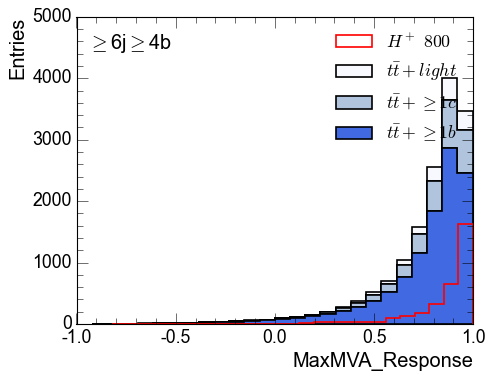

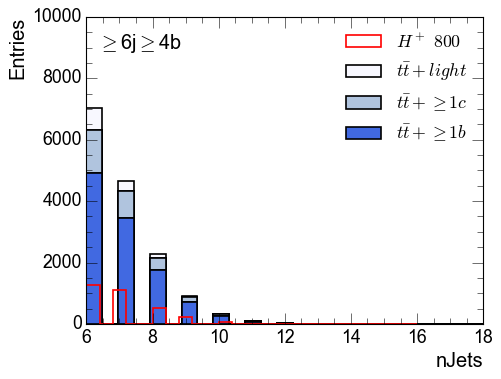

In [9]:
def simpleplotter(imass,i,region,signal,logy):
    issignalmsk = (df_mc.Hp_mass==imass)       
    signalleg = r"$H^+\ "+str(imass)+"$"
    
    plt.figure(figsize=(6.4,4.8),linewidth=0)
    ypos = 0.95

    if signal:
        plt.hist(df_mc[issignalmsk][feature_names[i]],bins=25,weights=df_mc[issignalmsk].weight,label=signalleg, color="r",linewidth=1.5,stacked=True,ec="r",histtype="step")
    plt.hist([ipd[feature_names[i]] for ipd in datasets],bins=25,weights=[ipd.weight for ipd in datasets],label=labels, color=colors,stacked=True,ec="k",linewidth=1.5,histtype="stepfilled")

    #axis legends adjusted to edge and change of font
    plt.xlabel(feature_names[i],horizontalalignment='right',x=1,fontproperties=fm.FontProperties(fname=fpath,size=18))
    plt.ylabel("Entries",horizontalalignment='right',y=1,fontproperties=fm.FontProperties(fname=fpath,size=18))
    if logy:
        plt.yscale("log")
        ypos = 0.6
    else:
        plt.ylim(0,plt.gca().get_ylim()[1]*1.25) #make the y range 25% higher and start from 0
    plt.gca().set_xticks(plt.gca().get_xticks().tolist()) #to control matplotlib errors
    plt.gca().set_yticks(plt.gca().get_yticks().tolist())
    
    if any([x-int(x) for x in plt.gca().get_xticks()])!=0.0:
        plt.gca().set_xticklabels([round(num,2) for num in plt.gca().get_xticks()], fontproperties=fm.FontProperties(fname=fpath,size=16)) #Format the labels of the ticks
    else:
        plt.gca().set_xticklabels([int(num) for num in plt.gca().get_xticks()], fontproperties=fm.FontProperties(fname=fpath,size=16)) #Format the labels of the ticks

    plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator()) #Plot more minor ticks

    if logy: #if logy plot, need to obtain the 10^ format and minor ticks 
        print(plt.gca().get_yticks())
        plt.gca().set_yticklabels(getlogticks(plt.gca().get_yticks()), fontproperties=fm.FontProperties(fname=fpath,size=16))
        plt.gca().yaxis.set_minor_locator(tck.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)))
    else:
        plt.gca().set_yticklabels([int(num) for num in plt.gca().get_yticks()], fontproperties=fm.FontProperties(fname=fpath,size=16))
        plt.gca().yaxis.set_minor_locator(tck.AutoMinorLocator())

    plt.gca().tick_params(length=10, width=0.5) #Longer ticks
    plt.gca().tick_params(which="minor",length=5, width=0.5)

    #To print some text in % position of the axes
    plt.text(ATLAS(plt.gca().get_xlim(),0.03),ATLAS(plt.gca().get_ylim(),ypos),labelsreg[region],va='top',ha='left',fontproperties=fm.FontProperties(fname=fpath,size=18))

    plt.legend(loc="best",prop=fm.FontProperties(fname=fpath,size=16),frameon=False)
    plt.show()

#tests
simpleplotter(800,feature_names.index("MaxMVA_Response"),"6jin4bin",signal=True,logy=False)
simpleplotter(800,0,"6jin4bin",signal=True,logy=False)

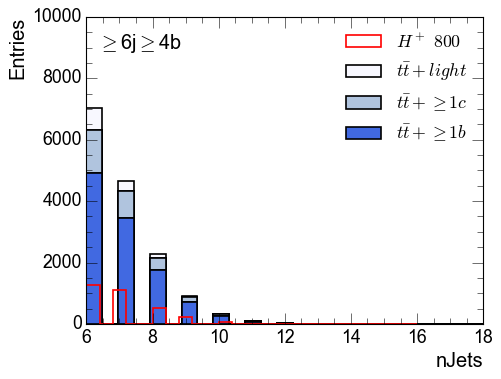

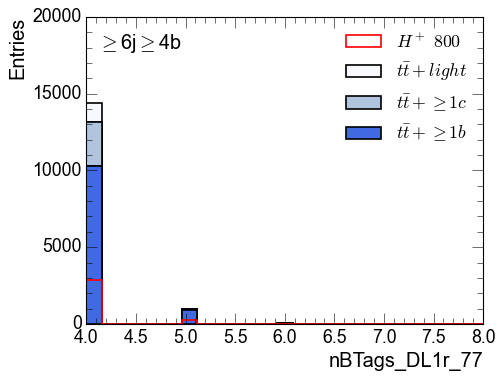

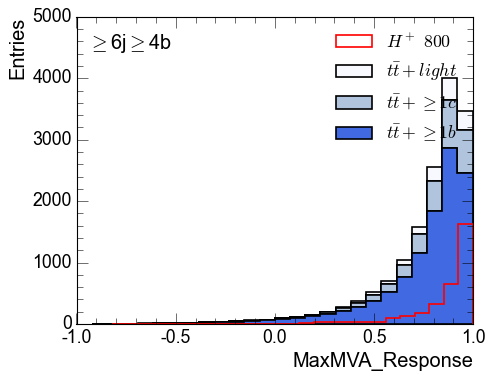

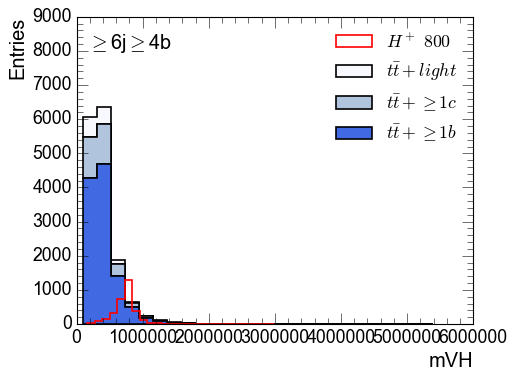

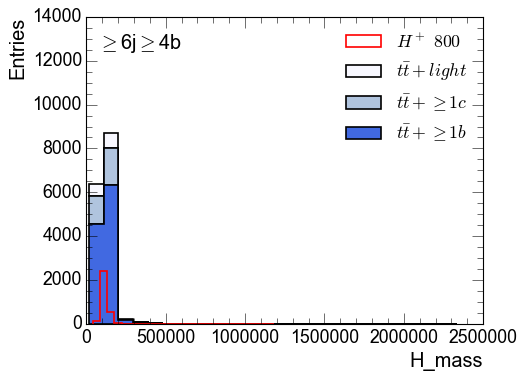

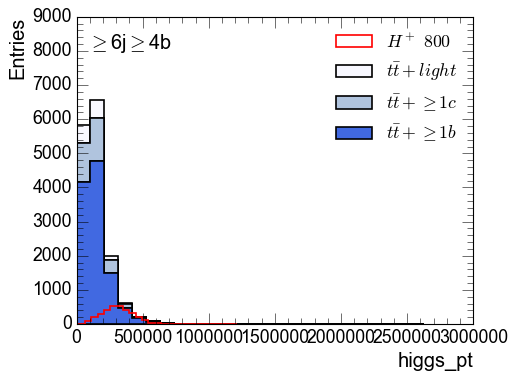

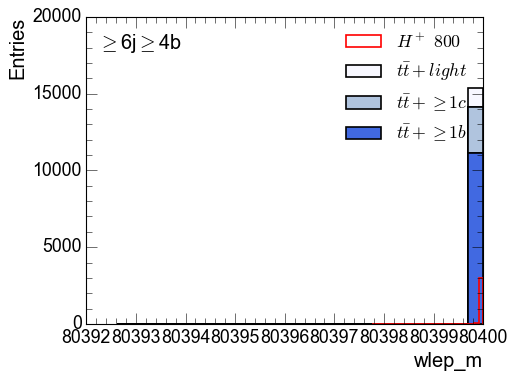

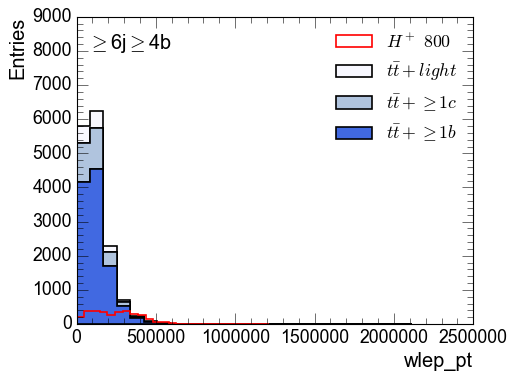

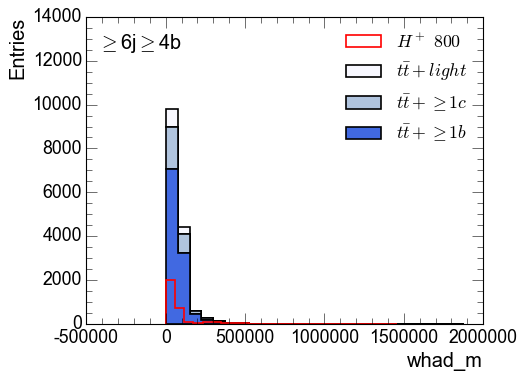

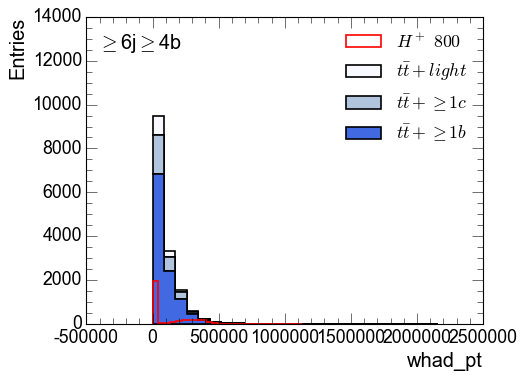

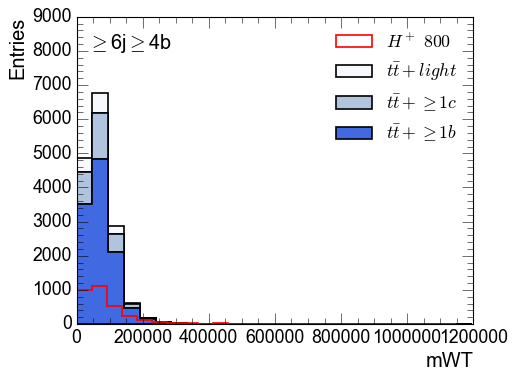

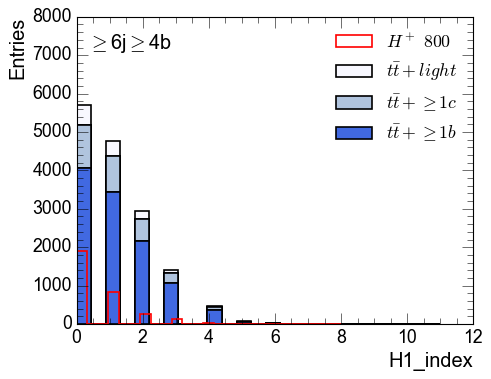

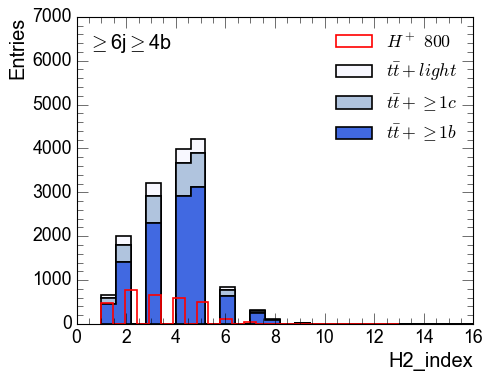

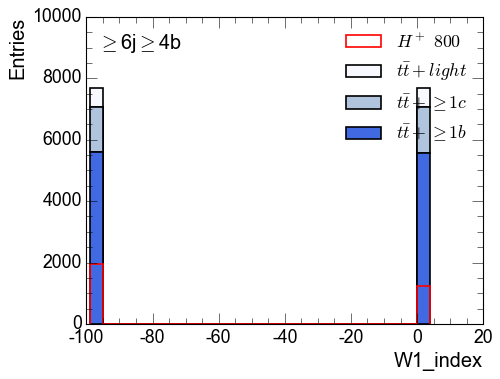

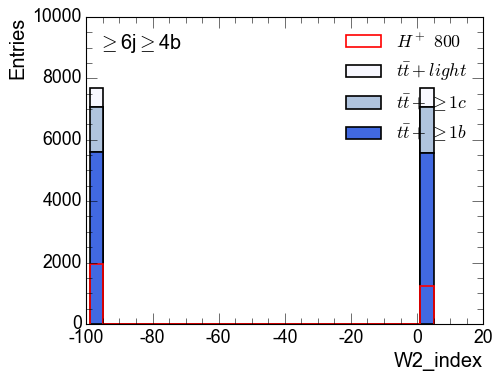

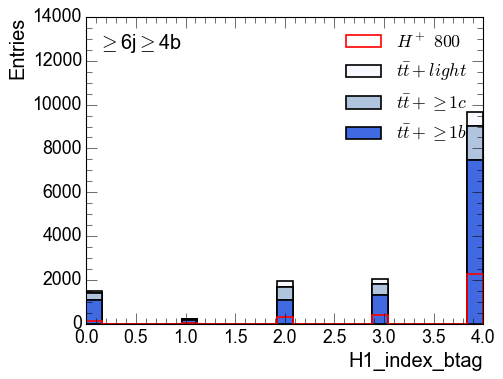

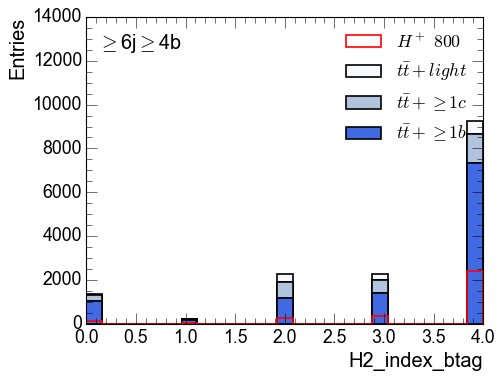

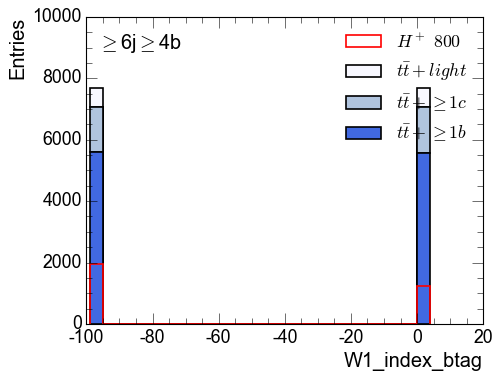

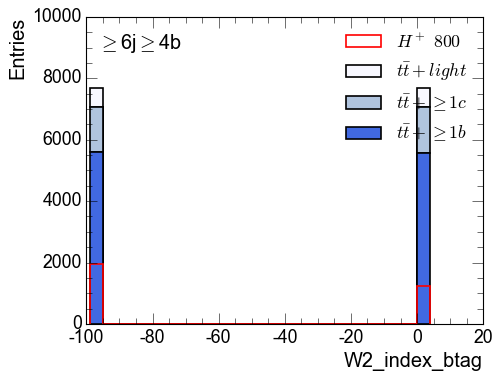

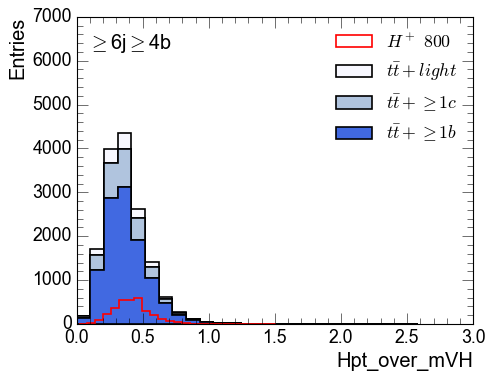

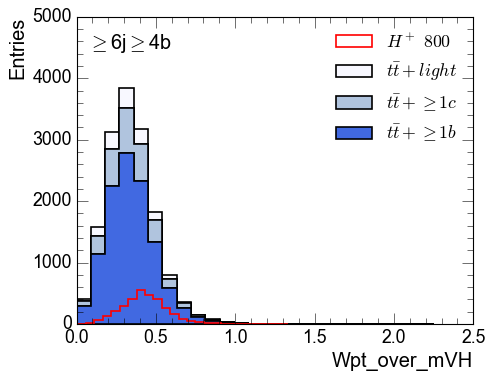

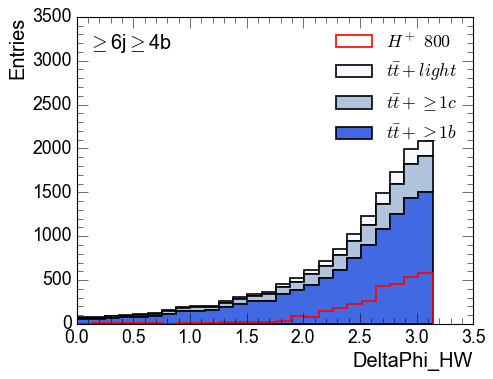

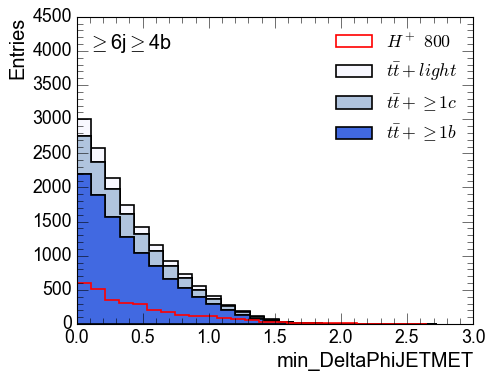

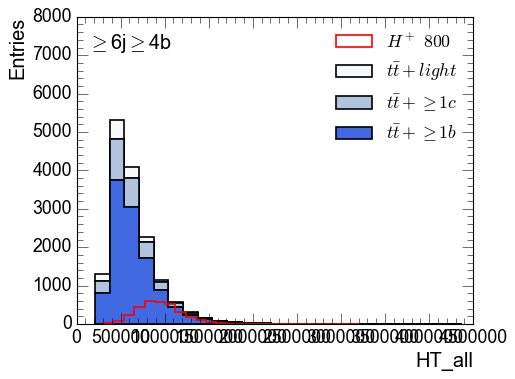

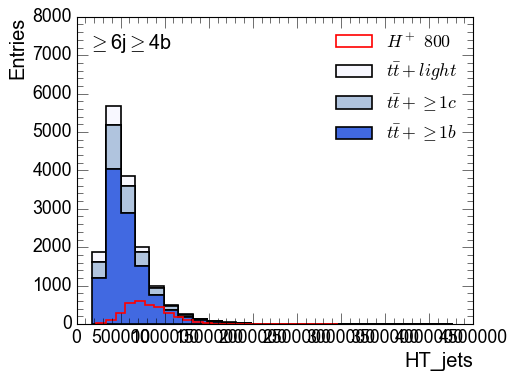

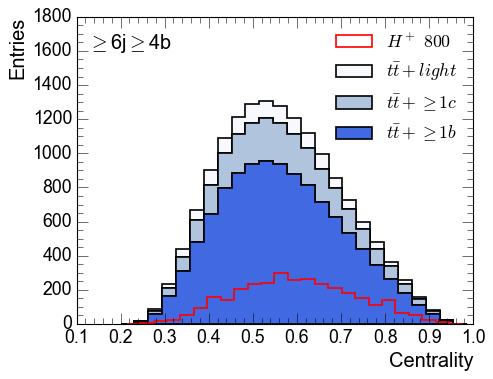

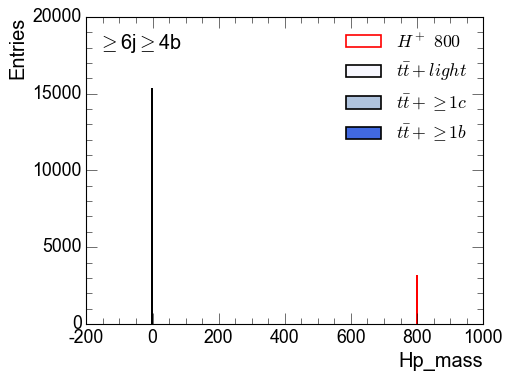

In [10]:
for ifeat in range(len(feature_names)):
    simpleplotter(800,ifeat,"6jin4bin",signal=True,logy=False)